# Reinforcement Learning - HW 1

## by Clarice Mottet

0. **[Part 0: Set Up](#part0)**
- **Objective**: Initialize programming environment.
- **Tasks:***
    - Set up libraries
    - Initialize global variables
    - Create functions to be used throughout notebook base on problem set up

1. **[Part 1: Policy Evaluation](#part1)**
- **Objective**: Create policies and evaluate their efficacy
- **Tasks:**
  - Lazy policy
  - Aggressive policy
  - Evaluate efficacy by directly soluving the Bellman equations

2. **[Part 2: Value Iteration and Policy Iteration](#part2)**
- **Objective**: Calculate optimal policy using value iteration and policy iteration
- **Tasks:**
  - Value iteration: create algorithm and plot
  - Policy iteration: create algorithm and plot
  - Compare methods by plotting the differenc ebetween the optimal value function and value functions of the policies from problem 1.

## <a id='part0'>Part 0: Set Up</a>
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Set up libraries
    - Initialize global variables
    - Create functions to be used throughout notebook base on problem set up

- Set up libraries

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


- Initialize global variables

In [64]:
N_MAX = 100
GAMMA = 0.9

Q_LOW = 0.51
Q_HIGH = 0.6

COST_LOW = 0.0
COST_HIGH = 0.01

ARRIVAL_RATE = 0.5

ACTION_LIST = [0, 1] #action_ind (low = 0, high = 1)

- Create functions to be used throughout notebook base on problem set up
    - reward functions
    - transition functions
    - evaluation functions
    - simulation functions

In [65]:
#reward functions

def action_cost(action_ind):
    if action_ind == 0:
        return COST_LOW
    else:
        return COST_HIGH

def reward_calc(x, action_ind):
    return -((x/N_MAX)**2) - action_cost(action_ind)

def reward_under_policy(pi):
    r_pi = np.zeros(N_MAX)
    for x in range(0, N_MAX):
        action_ind = None
        for a in ACTION_LIST:
            #assuming actions are never equal
            if pi[x,a] > 0.5:
                action_ind = a
        if action_ind == None:
            print(f'issue with action_ind at x: {x}')
        r_pi[x] = reward_calc(x, action_ind)
    return r_pi

In [95]:
#transitions functions

def reduction_rate(action_ind):
    if action_ind == 0:
        return Q_LOW
    else:
        return Q_HIGH
    
def transition_framework():
    #conditional matrix P(x, x_prime, a)
    P = np.zeros((N_MAX,N_MAX,2))
    for x in range(0,N_MAX):
        for a in ACTION_LIST:
            if x == 0:
                P[x, 0, a] = (1-ARRIVAL_RATE) + (reduction_rate(a))*(ARRIVAL_RATE)
                P[x, 1, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
            elif x == (N_MAX-1):
                P[x, N_MAX-2, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
                P[x, N_MAX-1, a] = (1-reduction_rate(a)) + (reduction_rate(a))*(ARRIVAL_RATE)
            else:
                #(decrement, increment)
                for x_prime in [x-1, x, x+1]:
                    if x_prime == (x-1):
                        #(1,0)
                        P[x, x_prime, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
                    if x_prime == x:
                        #(0,0) + (1,1)
                        P[x, x_prime, a] = (1-reduction_rate(a))*(1-ARRIVAL_RATE) + (reduction_rate(a))*(ARRIVAL_RATE)
                    if x_prime == (x+1):
                        #(0,1)
                        P[x, x_prime, a] = (1-reduction_rate(a))*(ARRIVAL_RATE)
    return P

def transition_under_policy(pi):
    P = transition_framework()

    #create transition matrix based on policy P(x, x_prime)
    P_pi = np.zeros((N_MAX,N_MAX))
    for x in range(N_MAX):
        for x_prime in [x-1, x, x+1]:
            if (x_prime < N_MAX) and (x_prime >= 0):
                for a in ACTION_LIST:
                    P_pi[x,x_prime] += P[x,x_prime,a]*pi[x,a]
    return P_pi

# transition matrix for policy pi
def transition(pi):
    P = transition_framework()

    X = np.size(P, 0)
    P_pi = np.zeros((X, X))
    for x in range(X):
        for y in range(X):
            P_pi[x, y] = np.sum(pi[x, :] * P[x, y, :])
    return P_pi

In [92]:
#evaluation functions

def value_under_policy(pi):
    P = transition_framework()
    r = reward_under_policy(pi)

    X = np.size(P,1)
    V_pi = np.zeros((X))

    # P_pi = transition_under_policy(pi)
    P_pi = transition(pi)
    # V_pi = np.linalg.solve((np.eye(X) - GAMMA*P_pi),r) #solves linear system V_pi = r_pi + gamma*P_pi*V_pi
    V_pi = np.linalg.inv(np.eye(X) - GAMMA*P_pi).dot(r)
    return V_pi


In [68]:
#simulation functions

def next_state(state_val, action_ind):
    increment_t = random.choices([0, 1], weights=[1-ARRIVAL_RATE, ARRIVAL_RATE])[0]
    decrement_t = random.choices([0, 1], weights=[1-reduction_rate(action_ind), reduction_rate(action_ind)])[0]
    net_t = increment_t - decrement_t
    return min(N_MAX-1, max(state_val + net_t, 0))

def plot_value_under_policy(V_pi, title):
    plt.figure(figsize=(5, 3))
    plt.plot(V_pi, linestyle = 'dotted')
    plt.xlabel('state')
    plt.ylabel('policy value')
    plt.title(title)
    plt.show()

## <a id='part1'>Part 1: Policy Evaluation</a>
- **Objective**: Create policies and evaluate their efficacy
- **Tasks:**
  - Lazy policy
  - Aggressive policy
  - Evaluate efficacy by directly soluving the Bellman equations


- Lazy policy: policy that always uses the low servive rate.

$$ \pi_{lazy}(x) = a_{low} $$

In [69]:
# P[x,y,a] gives the probability of moving from state x to state y when taking action a
# pi[x,a] = probability of picking action a in state x (either 0 or 1)
# P_pi[x,x']=P[x,x',pi[x]]
# policy maps (x,a) pair to probability of taking action a in (scalarized) state x

In [70]:
#lazy policy function

def policy_lazy():
    pi = np.zeros((N_MAX,2))
    for x in range(0,N_MAX):
        pi[x, 0] = 1 #action_ind (low = 0, high = 1)
        pi[x, 1] = 0
    return pi


In [93]:
#lazy policy implementation

pi_lazy = policy_lazy()
V_pi_lazy = value_under_policy(pi_lazy)


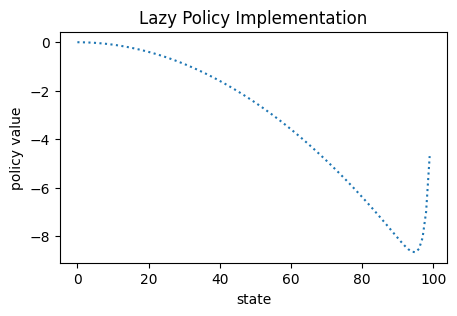

In [94]:
#lazy policy plot

plot_value_under_policy(V_pi_lazy, "Lazy Policy Implementation")

- Aggressive policy: policy that uses the low service rate for short queues and the high service rate for long queues

$$ \pi_{aggr}(x) = \begin{cases} a_{low}\ \text{if}\ x < 50 \\ a_{high}\ \text{otherwise}\ \end{cases} $$

In [73]:
#aggresive policy function

def policy_aggr():
    pi = np.zeros((N_MAX,2))
    for x in range(0,N_MAX):
        if x < 50:
            pi[x, 0] = 1 #action_ind (low = 0, high = 1)
            pi[x, 1] = 0
        else:
            pi[x, 0] = 0 
            pi[x, 1] = 1 #action_ind (low = 0, high = 1)
    return pi


In [82]:
#aggresive policy implementation

pi_aggr = policy_aggr()
V_pi_aggr = value_under_policy(pi_aggr)


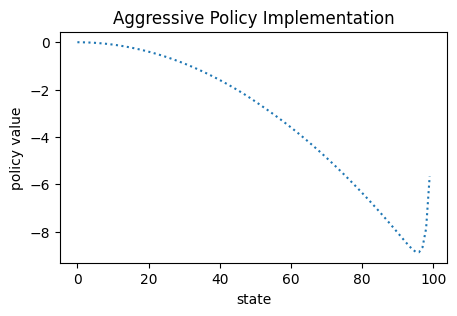

In [75]:
#aggresive policy plot

plot_value_under_policy(V_pi_aggr, "Aggressive Policy Implementation")


- Evaluate efficacy by directly soluving the Bellman equations

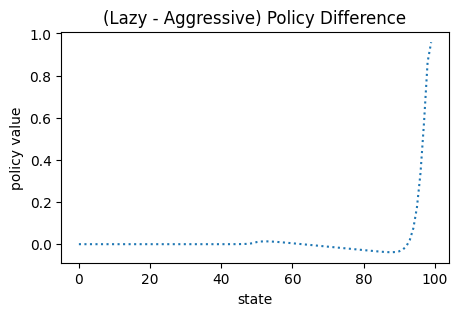

In [76]:
V_pi_diff = np.zeros(N_MAX)
for x in range(0, N_MAX):
    V_pi_diff[x] = V_pi_lazy[x] - V_pi_aggr[x]

plot_value_under_policy(V_pi_diff, "(Lazy - Aggressive) Policy Difference")

## <a id='part2'>Part 2: Value Iteration and Policy Iteration</a>
- **Objective**: Calculate optimal policy using value iteration and policy iteration
- **Tasks:**
  - Value iteration: create algorithm and plot
  - Policy iteration: create algorithm and plot
  - Compare methods by plotting the differenc ebetween the optimal value function and value functions of the policies from problem 1.